# Business Problem

# Data Understanding

In [67]:
# Import Modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import nltk
from sklearn.preprocessing import LabelEncoder
from matplotlib.ticker import MaxNLocator
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag, FreqDist
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer, TweetTokenizer
from nltk import tokenize as tok
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, recall_score, accuracy_score, precision_score, f1_score, classification_report

In [2]:
df = pd.read_csv('../data/judge-1377884607_tweet_product_company.csv', encoding= 'unicode_escape')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [4]:
df.head(10)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product
6,NaN,NaN,No emotion toward brand or product
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion


In [5]:
df.tail()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product
9092,Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...,NaN,No emotion toward brand or product


In [6]:
# Dropped the sole blank tweet_text field
df.drop(index=[6], inplace=True)

In [7]:
df['emotion_in_tweet_is_directed_at'].isna().sum()

5801

In [8]:
df["tweet_text"][6520]

"RT @mention RT @mention Can't be at #sxsw? download their free music mix on itunes {link} cc: @mention"

In [9]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [10]:
df_ict = df[df['is_there_an_emotion_directed_at_a_brand_or_product'] == "I can't tell"]

In [11]:
df = df[df['is_there_an_emotion_directed_at_a_brand_or_product'] != "I can't tell"]

## Preprocessing Data

In [12]:
#le = LabelEncoder()
#df['target'] = le.fit_transform(df['is_there_an_emotion_directed_at_a_brand_or_product'])
df['target'] = df['is_there_an_emotion_directed_at_a_brand_or_product']

In [13]:
#custom regular expression cleaning we found online for cleaning tweets
isURL = re.compile(r'http[s]?:// (?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', re.VERBOSE | re.IGNORECASE)
isRTusername = re.compile(r'^RT+[\s]+(@[\w_]+:)',re.VERBOSE | re.IGNORECASE) #r'^RT+[\s]+(@[\w_]+:)'
isEntity = re.compile(r'@[\w_]+', re.VERBOSE | re.IGNORECASE)

In [14]:
def clean_tweet(row):
    row = isURL.sub("",row)
    row = isRTusername.sub("",row)
    row = isEntity.sub("",row)
    return row

In [15]:
df['clean'] = df['tweet_text'].apply(lambda row:clean_tweet(row))

In [16]:
RE_PUNCTUATION = '|'.join([re.escape(x) for x in string.punctuation])  
df['clean'] = df['clean'].str.replace(RE_PUNCTUATION, "")

In [17]:
lemmatizer = WordNetLemmatizer()

def tokenize_lem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in tok.sent_tokenize(text) for word in tok.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return [lemmatizer.lemmatize(token) for token in filtered_tokens]

In [18]:
df['clean'] = df['clean'].apply(tokenize_lem)


In [19]:
df['clean'].head()

0    [i, have, a, 3g, iphone, after, hr, tweeting, ...
1    [know, about, awesome, ipadiphone, app, that, ...
2    [can, not, wait, for, ipad, also, they, should...
3    [i, hope, this, year, festival, isnt, a, crash...
4    [great, stuff, on, fri, sxsw, marissa, mayer, ...
Name: clean, dtype: object

In [20]:
sw = stopwords.words('english')
customsw = ['sxsw', 'link']
sw.extend(customsw)

In [21]:
# Replace None with appropriate code
def remove_stopwords(token_list):
    """
    Given a list of tokens, return a list where the tokens
    that are also present in stopwords_list have been
    removed
    """
    stopwords_r = [token for token in token_list if token not in sw]
    return stopwords_r

In [22]:
df['clean'] = df['clean'].apply(remove_stopwords)

In [23]:
df['clean'].iloc[3128]

['big',
 'line',
 'googlebing',
 'session',
 'people',
 'line',
 'saying',
 'one',
 'ballroom']

In [24]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,target,clean
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,Negative emotion,"[3g, iphone, hr, tweeting, riseaustin, wa, dea..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,Positive emotion,"[know, awesome, ipadiphone, app, youll, likely..."
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,Positive emotion,"[wait, ipad, also, sale]"
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,Negative emotion,"[hope, year, festival, isnt, crashy, year, iph..."
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,Positive emotion,"[great, stuff, fri, marissa, mayer, google, ti..."


In [25]:
# https://gitlab.com/praj88/twitter-analytics/blob/master/scripts/twitter-analytics.ipynb where we found the custom cleaning
# functions

In [26]:
def visualize_top_10(freq_dist, title):

    # Extract data for plotting
    top_10 = list(zip(*freq_dist.most_common(10)))
    tokens = top_10[0]
    counts = top_10[1]

    # Set up plot and plot data
    fig, ax = plt.subplots()
    ax.bar(tokens, counts)

    # Customize plot appearance
    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis="x", rotation=90)
    

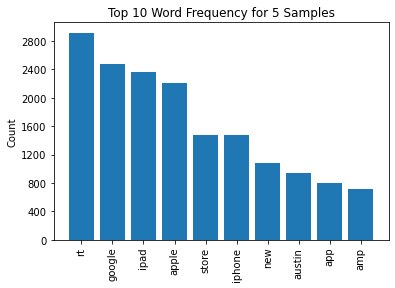

In [27]:
sample_freq_dist = FreqDist(df["clean"].explode())
visualize_top_10(sample_freq_dist, "Top 10 Word Frequency for 5 Samples")

In [28]:
df['clean'] = [','.join(map(str, l)) for l in df['clean']]

In [29]:
X = pd.DataFrame(df, columns = ['clean'])
y = df['target']

In [30]:
X.head()

,clean
0,"3g,iphone,hr,tweeting,riseaustin,wa,dead,need,..."
1,"know,awesome,ipadiphone,app,youll,likely,appre..."
2,"wait,ipad,also,sale"
3,"hope,year,festival,isnt,crashy,year,iphone,app"
4,"great,stuff,fri,marissa,mayer,google,tim,oreil..."


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    test_size=0.25)

In [32]:
X_train.head()

,clean
3363,"great,time,google,party,sxswi"
3204,"fromubersocial,iphone,app,store,includes,uberg..."
4460,"town,sure,check,u,using,google,place,foursquar..."
2311,"ironic,tee,ha,usurped,ipad,hipstergeekstartup,..."
6298,"rt,marissa,mayer,google,connect,digital,amp,ph..."


In [56]:
tfidf = TfidfVectorizer()

In [57]:
X_train_vectorized = tfidf.fit_transform(X_train['clean'])

In [58]:
X_train_vectorized

<6702x8391 sparse matrix of type '<class 'numpy.float64'>'
	with 63520 stored elements in Compressed Sparse Row format>

In [59]:
X_train_vec = pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names())

In [60]:
# Transform test data using TF-IDF Vectorizer
X_test_vectorized = tfidf.transform(X_test['clean'])
X_test_vectorized

<2234x8391 sparse matrix of type '<class 'numpy.float64'>'
	with 19987 stored elements in Compressed Sparse Row format>

In [61]:
X_test_vec = pd.DataFrame.sparse.from_spmatrix(X_test_vectorized, columns=tfidf.get_feature_names())

# Modeling

#### Multinomial Naive Bayes

0.8075091084599232

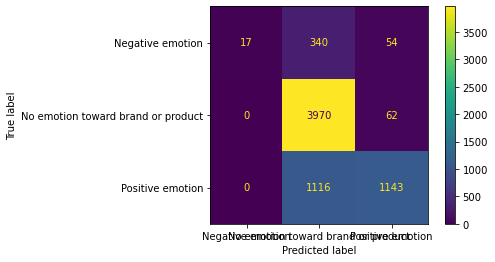

In [62]:
mnb = MultinomialNB()

mnb.fit(X_train_vec, y_train)

mnb_y_hat = mnb.predict(X_train_vec)


plot_confusion_matrix(mnb, X=X_train_vec, y_true=y_train)

precision_score(y_train, mnb_y_hat, average='weighted')

In [63]:
print(classification_report(y_train, mnb_y_hat))

                                    precision    recall  f1-score   support

                  Negative emotion       1.00      0.04      0.08       411
No emotion toward brand or product       0.73      0.98      0.84      4032
                  Positive emotion       0.91      0.51      0.65      2259

                          accuracy                           0.77      6702
                         macro avg       0.88      0.51      0.52      6702
                      weighted avg       0.81      0.77      0.73      6702



#### Logistic Regression

0.8273998168112187

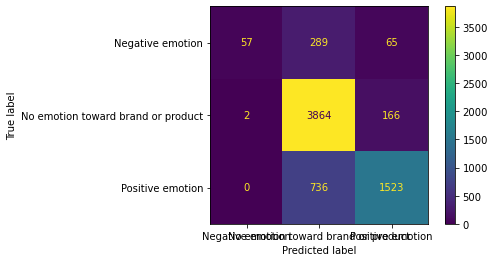

In [68]:
log = LogisticRegression()
log.fit(X_train_vec, y_train)
log_y_hat = log.predict(X_train_vec)

plot_confusion_matrix(log, X_train_vec, y_train)
precision_score(y_train, log_y_hat, average='weighted')

#### Linear Support Vector Machine

0.8817181982761939

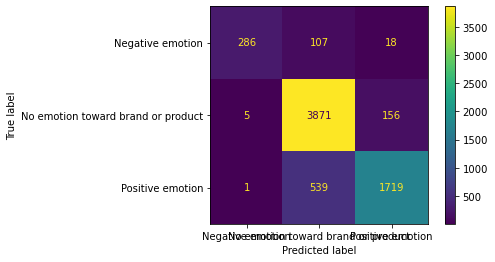

In [64]:
lsv = SGDClassifier(random_state=42)

lsv.fit(X_train_vec, y_train)
lsv_y_hat = lsv.predict(X_train_vec)

plot_confusion_matrix(lsv, X_train_vec, y_train)

precision_score(y_train, lsv_y_hat, average='weighted')

#### RF Classifier

0.9908982393315429

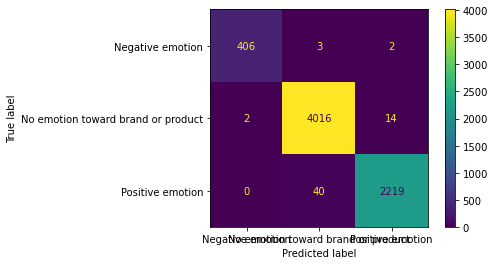

In [71]:
rf = RandomForestClassifier()

rf.fit(X_train_vec, y_train)
rf_y_hat = rf.predict(X_train_vec)

plot_confusion_matrix(rf, X=X_train_vec, y_true=y_train)

precision(y_train, rf_y_hat, average='weighted')

In [66]:
print(classification_report(y_train, rf_y_hat))

                                    precision    recall  f1-score   support

                  Negative emotion       1.00      0.99      0.99       411
No emotion toward brand or product       0.99      1.00      0.99      4032
                  Positive emotion       0.99      0.98      0.99      2259

                          accuracy                           0.99      6702
                         macro avg       0.99      0.99      0.99      6702
                      weighted avg       0.99      0.99      0.99      6702



In [44]:
#rf_y_hat = rf.predict(X_test_vec)

#plot_confusion_matrix(rf, X=X_test_vec, y_true=y_test)

#precision_score(y_test, rf_y_hat, average='weighted')

### Model Evaluation

In [ ]:
# This function will allow for quick cross-validation of the f1 score for each of our models.
def cross_val(model, X, y, kfolds=10):
    """ Perform cross-validated scoring and store/print results """
    f1_results = cross_val_score(model, X, y, cv=kfolds, scoring='f1')
    f1_mean = np.mean(f1_results)
    f1_median = np.median(f1_results)
    f1_std = np.std(f1_results)
    print(f"Mean f1 score: ", {f1_mean}, ".")
    print(f"Median f1 score: ", {f1_median}, ".")
    print(f"Standard Deviation in f1 score: ", {f1_std}, ".")  

In [ ]:

# http://michael-harmon.com/blog/NLP1.html
from wordcloud import WordCloud, STOPWORDS

def plot_wordcloud(df: pd.DataFrame, category: str, target: int) -> None:
    words = " ".join(train_df[train_df["target"] == target]["text"].values)

    plt.rcParams['figure.figsize'] = 10, 20
    wordcloud = WordCloud(stopwords=STOPWORDS, 
                          background_color="white",
                          max_words=1000).generate(words)

    plt.title("WordCloud For {}".format(category))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()